In [181]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn import TCN


In [182]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.857156,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.731959,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.883473,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.908735,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.804051,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2019-12-30,AMZN,0.748412,93.699997,94.199997,92.030998,92.344498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7532,2019-12-30,GOOG,0.676151,67.500000,67.650002,66.700996,66.806999,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7533,2019-12-30,GOOGL,0.705876,67.840500,67.849998,66.891998,66.985497,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7534,2019-12-30,MSFT,0.762997,158.990005,159.020004,156.729996,157.589996,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [183]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [184]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1252, 17)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.857156  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.744531  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.769826  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.773995  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.770458  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1246  2019-12-20     0.775477  70.557503  70.662498  69.639999  69.860001   
1247  2019-12-23     0.759453  70.132500  71.062500  70.092499  71.000000   
1248  2019-12-24     0.742264  71.172501  71.222504  70.730003  71.067497   
1249  2019-12-26     0.670220  71.205002  72.495003  71.175003  72.477501   
1250  2019-12-27     0.760582  72.779999  73.492500  72.029999  72.449997   

      unrate  psr       m2    dspic      pce    reer       

In [185]:
ticker='TSLA'

In [186]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.741818,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.646626,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.696584,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.654833,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.615611,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [187]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [188]:
dates = pd.to_datetime(df['Date'])

In [189]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [190]:
df_for_training = df[cols].astype(float)

In [191]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [192]:
print(scaled_data)

[[0.78512475 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.57178167 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.68374619 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.47142104 0.97577552 0.99347221 ... 0.57323507 1.         1.        ]
 [0.38496901 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.44112774 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]]


In [193]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [194]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [195]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [196]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1250, 7, 16)
(1250, 1)


In [197]:
X_train=X[0:1125,:]
X_test=X[1125:,:]
y_train=y[0:1125,:]
y_test=y[1125:,:]

#early stopping


Epoch 1/1000
6/6 [==============================] - 3s 127ms/step - loss: 0.9346 - val_loss: 0.0573
Epoch 2/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.4899 - val_loss: 0.0118
Epoch 3/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.2266 - val_loss: 0.0357
Epoch 4/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1209 - val_loss: 0.0164
Epoch 5/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0675 - val_loss: 0.0467
Epoch 6/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0702 - val_loss: 0.0549
Epoch 7/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0564 - val_loss: 0.0154


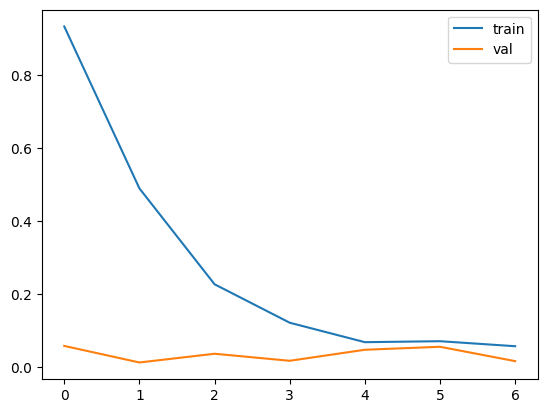

4/4 [==============================] - 0s 23ms/step
(125,)
(125,)


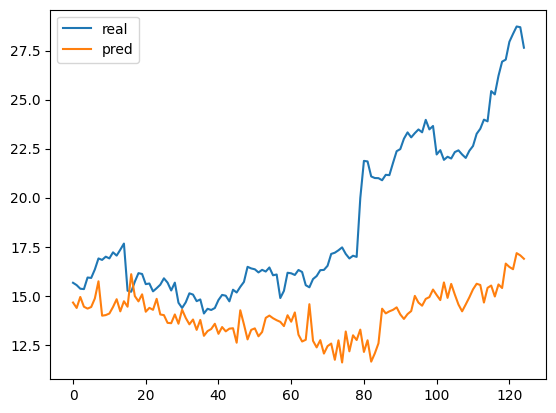

Epoch 1/1000
12/12 [==============================] - 2s 61ms/step - loss: 0.9390 - val_loss: 0.0642
Epoch 2/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.3178 - val_loss: 0.0359
Epoch 3/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0806 - val_loss: 0.0420
Epoch 4/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0554 - val_loss: 0.0103
Epoch 5/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0464 - val_loss: 0.0046
Epoch 6/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0371 - val_loss: 0.0025
Epoch 7/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0324 - val_loss: 0.0039
Epoch 8/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0281 - val_loss: 0.0023
Epoch 9/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0264 - val_loss: 0.0023
Epoch 10/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0214 - val_loss:

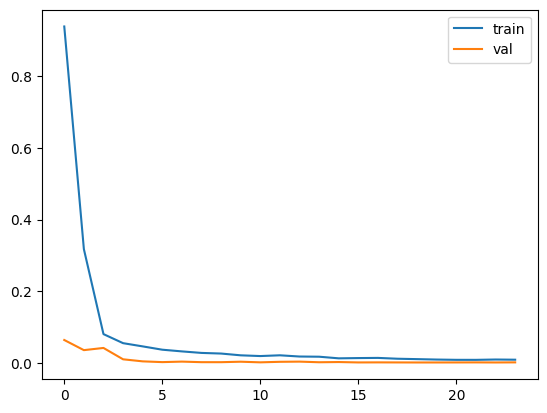

4/4 [==============================] - 0s 2ms/step
(125,)
(125,)


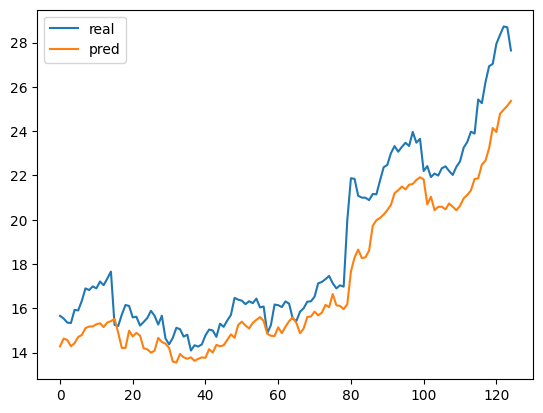

Epoch 1/1000
18/18 [==============================] - 3s 48ms/step - loss: 0.2896 - val_loss: 0.1559
Epoch 2/1000
18/18 [==============================] - 0s 10ms/step - loss: 0.0601 - val_loss: 0.0604
Epoch 3/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0463 - val_loss: 0.0859
Epoch 4/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.0632 - val_loss: 0.0212
Epoch 5/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0386 - val_loss: 0.2355
Epoch 6/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0618 - val_loss: 0.0334
Epoch 7/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.0205 - val_loss: 0.0500
Epoch 8/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.0139 - val_loss: 0.0306
Epoch 9/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 10/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.01

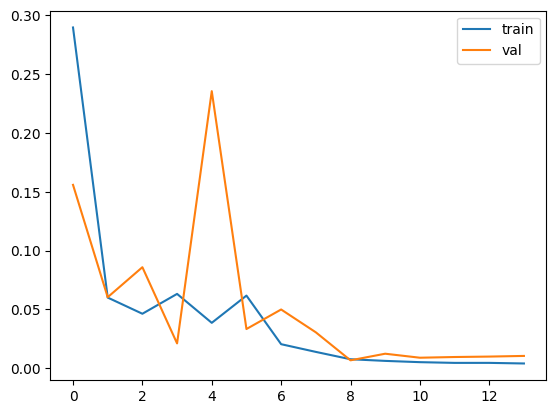

4/4 [==============================] - 0s 2ms/step
(125,)
(125,)


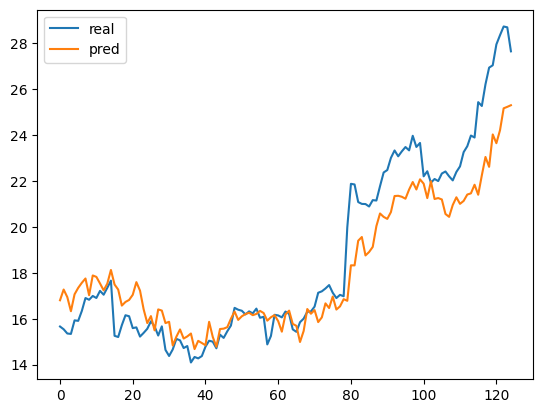

Epoch 1/1000
24/24 [==============================] - 3s 30ms/step - loss: 1.4299 - val_loss: 0.5140
Epoch 2/1000
24/24 [==============================] - 0s 8ms/step - loss: 0.3405 - val_loss: 0.0495
Epoch 3/1000
24/24 [==============================] - 0s 8ms/step - loss: 0.1674 - val_loss: 0.0051
Epoch 4/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.1536 - val_loss: 0.0604
Epoch 5/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.1295 - val_loss: 0.0096
Epoch 6/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.0362 - val_loss: 0.0107
Epoch 7/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.0275 - val_loss: 0.0050
Epoch 8/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.0238 - val_loss: 0.0205
Epoch 9/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.0209 - val_loss: 0.0049
Epoch 10/1000
24/24 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.005

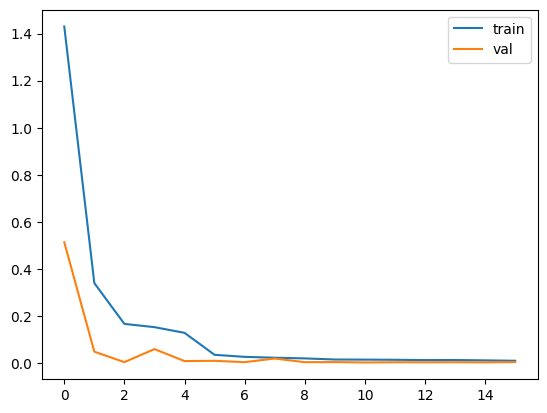

4/4 [==============================] - 0s 2ms/step
(125,)
(125,)


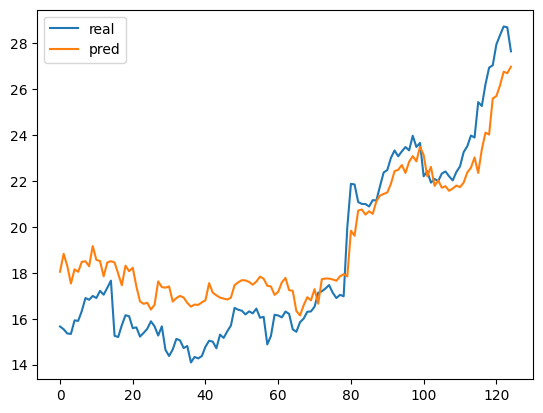

Epoch 1/1000
30/30 [==============================] - 3s 27ms/step - loss: 1.0638 - val_loss: 0.1409
Epoch 2/1000
30/30 [==============================] - 0s 8ms/step - loss: 0.1301 - val_loss: 0.0626
Epoch 3/1000
30/30 [==============================] - 0s 8ms/step - loss: 0.1099 - val_loss: 0.0500
Epoch 4/1000
30/30 [==============================] - 0s 8ms/step - loss: 0.0867 - val_loss: 0.0660
Epoch 5/1000
30/30 [==============================] - 0s 8ms/step - loss: 0.0962 - val_loss: 0.0222
Epoch 6/1000
30/30 [==============================] - 0s 8ms/step - loss: 0.0461 - val_loss: 0.0268
Epoch 7/1000
30/30 [==============================] - 0s 8ms/step - loss: 0.0507 - val_loss: 0.0369
Epoch 8/1000
30/30 [==============================] - 0s 8ms/step - loss: 0.0375 - val_loss: 0.0268
Epoch 9/1000
30/30 [==============================] - 0s 8ms/step - loss: 0.0263 - val_loss: 0.0175
Epoch 10/1000
30/30 [==============================] - 0s 8ms/step - loss: 0.0179 - val_loss: 0.021

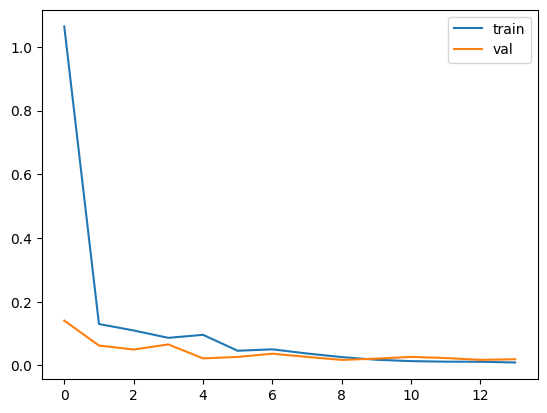

4/4 [==============================] - 0s 3ms/step
(125,)
(125,)


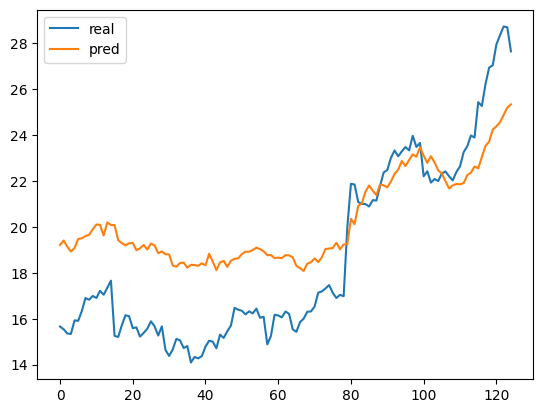

In [198]:
tscv = TimeSeriesSplit(n_splits=5)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=5)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    model.add(
     TCN(
         input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_size=5,
         dilations=[1, 2, 4, 8, 16, 32],
         return_sequences=False,
        activation='relu',
            nb_stacks=1,
            nb_filters=64,
         padding='causal',
         dropout_rate=0.3,
         kernel_initializer='he_normal',
     )   
    )
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape

    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    

    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()
